- http://www.universalteacherpublications.com/univ/ebooks/or/index1.htm
- https://katex.org/docs/supported.html

<img src="./images/Enexis_JADS.png" alt="Enexis JADS" style="width:12%; float:right">

# Queuing Theory (Waiting Line Models)

http://www.universalteacherpublications.com/univ/ebooks/or/Ch10/mmcex.htm


In [21]:
# Setup file for the MMC simulation
# packages
import salabim as sim
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from datetime import datetime
from scipy.special import factorial

# https://brandfetch.com/enexis.nl?view=library&library=default&collection=colors

ENEXIS_G_0 = '#B6D300'
ENEXIS_G_1 = '#BDDB00'
ENEXIS_G_2 = '#A3C100'
ENEXIS_P_0 = '#DA1369'
ENEXIS_P_1 = '#EE6DAE'
ENEXIS_P_2 = '#DF0073'
ENEXIS_B_0 = '#04296C'


In [22]:
# Fix the utilization on 96% and vary the number of servers
arrival_rate = 48 / 60  # 48 EVs per hour
processing_rate = 50 / 60  # 50 EVs per hour

# Create a list with EVSE's
EVSES = range(1, 31)
sim_time = 3000  # 3000 minutes = 50 hours
sim_reps = 20  # 20 simulations

# Create a string with the simulation session name
sim_session_name = (
    "df_EVSE_"
    + str(EVSES[0])
    + "-"
    + str(EVSES[-1])
    + "_time_"
    + str(sim_time)
    + "_reps_"
    + str(sim_reps)
    + ".csv"
)

print(sim_session_name)

df_EVSE_1-30_time_3000_reps_20.csv


## M/M/C Queuing System (∞/FIFO)

It is a queuing model where the arrivals of EV's follow a Poisson process, charging times are exponentially distributed and there are **C** EVSE's (Electric Vehicle Supply Equipment). In other words, it is a system with Poisson input, exponential waiting time and Poisson output.

Queue capacity of the system is infinite with first in first out mode. The first **M** in the notation stands for Poisson input (= exponential distribution of interarrival times), second **M** for Poisson output (= exponential distribution of processing times), **C** for the number of EVSE's and ∞ for infinite capacity of the system. The EV's will be charged in the order of arrival, hence FIFO (First In, First Out).

### Approach (verification & validation)

The following approach will be taken to asure that the simulations results are valid and the model can be used to evaluate different control strategies. 

#### 1. M/M/1/∞/FIFO

Code the theorectical mathematical formula's for a M/M/1/∞/FIFO in python and compare the outcome with known cases from theory, see example 1-5. This to validate the implementation.

#### 2. M/M/C/∞/FIFO

Code the theorectical mathematical formula's for a M/M/C/∞/FIFO in python and compare the results for **C=1** with the former M/M/1/∞/FIFO implementation.

#### 3. Theory versus Simulation

Simulate the M/M/C/∞/FIFO model in python for a range of C (1-10). Validate the results by comparing to the theoretical outcome from the M/M/C/∞/FIFO model.

###  Theoretical Formulas 

Based upon Queueing Theory we implement the known theoretical formulas in python using the following parameters. 

 ID    | parameter                | description
:------|:-------------------------|:--------------------------------------------------------------
 *M*   | arrival_rate $(\lambda)$ | mean arrivals in EV's/hour as poisson arrival distribution.
 *M*   | processing_rate $(\mu)$  | mean charging capacity in EV's/hour as expontential distribution.
 *C*   | EVSE's $(c)$             | number of Electrical Vehicle Supply Equipment's (EVSE) 



#### M/M/1/∞/FIFO

##### Formulas

 Performance Indicator                                    | Formula 
:---------------------------------------------------------|:--------
 utilization  ($\rho$)                                    | $\cfrac{\lambda}{\mu}$
 Probability of zero unit in the queue ($P_o$)            | $1 - \cfrac{\lambda}{\mu}$
 Average queue length ($L_q$ )                            | $\cfrac{\lambda^2}{\mu(\mu-\lambda)}$
 Average number of units in the system ($L_s$)            | $\cfrac{\lambda}{\mu-\lambda}$
 Average waiting time of an arrival ($W_q$)               | $\cfrac{\lambda}{\mu(\mu-\lambda)}$
 Average waiting time of an arrival in the system ($W_s$) | $\cfrac{1}{\mu-\lambda}$



##### Python function: ```mm1(lamb, mu)```


In [23]:
# Queueing Theory Formulas
# ------------------------
# note: this formula is not used in the simulation
# it is used to check the outcome of the following mmc formula for c=1
# https://en.wikipedia.org/wiki/M/M/1_queue

def mm1(lamb, mu):
    """M/M/1 queueing theory formula"""
    rho = lamb / mu  # utilization factor
    P0 = 1 - rho  # probability of no customers in the system
    Lq = rho**2 / (1 - rho)  # average number of customers in the queue
    Ls = rho / (1 - rho)  # average number of customers in the system
    Wq = rho / (mu - lamb)  # average time a customer spends in the queue
    Ws = 1 / (mu - lamb)  # average time a customer spends in the system
    return {
        "lambda": lamb.__round__(2),
        "mu": mu.__round__(2),
        "c": 1,
        "RO": rho,
        "P0": P0,
        "Lq": Lq,
        "Wq": Wq,
        "Ls": Ls,
        "Ws": Ws,
    }
 
def print_mm1(lamb, mu):
    print(
        pd.DataFrame(
            mm1(lamb, mu), index=[0]).to_string(index=False))


##### Validation

See Examples 1-5 at the end of this document

#### M/M/C/∞/FIFO

##### Formulas

 performance indicator                                    | Formula                                                                                              |
:---------------------------------------------------------|:-----------------------------------------------------------------------------------------------------|
 utilization RO                                             | $\rho = \cfrac{\lambda}{c\mu}$                                                                       |
 1/Probability of zero unit in the queue $\cfrac{1}{P_0}$ | $\displaystyle\sum_{n=0}^{c-1} \cfrac{(\lambda/\mu)^n}{n!} + \cfrac{(\lambda/\mu)^c}{c!} * \cfrac{1} {1-\rho}$ |
 Average queue length ($L_q$ )                            | $P_0 * \cfrac{(\lambda/\mu)^c}{c!} * \cfrac{\rho}{(1-\rho)^2}$                                       |  
 Average number of units in the system ($L_s$)            | $L_q + \cfrac{\lambda}{\mu}$                                                                         |
 Average waiting time of an arrival ($W_q$)               | $\cfrac{1}{\lambda} * L_q$                                                                           |
 Average waiting time of an arrival in the system ($W_s$) | $W_q + \cfrac{1}{\mu}$                                                                               | 

##### Python function: ```mmc(lamb, mu, c)```

In [24]:
def mmc(arrival_rate, processing_rate, charging_stations, decimals=2):
    """M/M/c queueing theory formula"""
    lamb = arrival_rate
    mu = processing_rate
    c = charging_stations
    # utilization factor
    rho = lamb / (c * mu)
    # probability of no customers in the system
    P0 = 1 / (
        sum([(c * rho) ** n / factorial(n) for n in range(c)])
        + (c * rho) ** c / (factorial(c) * (1 - rho))
    )
    # average number of customers in the system
    Lq = P0 * rho / (1 - rho) ** 2 * (c * rho) ** c / factorial(c)
    # average number of customers in the queue
    Ls = Lq + c * rho
    # average time a customer spends in the queue
    Wq = 1 / lamb * Lq
    # average time a customer spends in the system
    Ws = 1 / mu + Wq
    return {
        "lambda": lamb.__round__(decimals),
        "mu": mu.__round__(decimals),
        "c": c,
        "RO": rho.__round__(decimals),
        "P0": P0.__round__(decimals),
        "Lq": Lq.__round__(decimals),
        "Wq": Wq.__round__(decimals),
        "Ls": Ls.__round__(decimals),
        "Ws": Ws.__round__(decimals),
    }

def print_mmc(arrival_rate, processing_rate, charging_stations, decimals=2):
    print(
        pd.DataFrame(
            mmc(arrival_rate, processing_rate, charging_stations, decimals=2), 
            index=[0]
            ).to_string(index=False)
            )

##### Validation

See Examples 1-5 at the end of this document

###### Validation of *mmc* against *mm1*

The following table shows that the mmc function with **c =1** has the same output as the simple mm1 function.


In [25]:
# mm1 function 
print_mm1(40 / 60, 50 / 60)
print("\n")

# mmc function with additional parameter c for teh number of servers. (c=1 is the same as mm1)
print_mmc(40 / 60, 50 / 60, 1)

 lambda   mu  c  RO  P0  Lq  Wq  Ls  Ws
   0.67 0.83  1 0.8 0.2 3.2 4.8 4.0 6.0


 lambda   mu  c  RO  P0  Lq  Wq  Ls  Ws
   0.67 0.83  1 0.8 0.2 3.2 4.8 4.0 6.0


#### Theoretical results for C (1-10)

For a range of EVSE's from 1-10 we calculate the performance of the system. 

We take a Utilization of 96% to create enough revenue.

##### Results

In [26]:
# Create an empty list to store the dictionaries
dict_list = []

# Loop over the list
for i in EVSES:
    # Each iteration generates a dictionary that represents a row of data

    row_dict = mmc(arrival_rate * i, processing_rate, i)
    # Append the dictionary to the list
    dict_list.append(row_dict)

# Convert the list of dictionaries into a DataFrame
dfMathResults = pd.DataFrame(dict_list)

print(dfMathResults)

    lambda    mu   c    RO    P0     Lq     Wq     Ls     Ws
0      0.8  0.83   1  0.96  0.04  23.04  28.80  24.00  30.00
1      1.6  0.83   2  0.96  0.02  22.57  14.11  24.49  15.31
2      2.4  0.83   3  0.96  0.01  22.21   9.25  25.09  10.45
3      3.2  0.83   4  0.96  0.00  21.91   6.85  25.75   8.05
4      4.0  0.83   5  0.96  0.00  21.64   5.41  26.44   6.61
5      4.8  0.83   6  0.96  0.00  21.40   4.46  27.16   5.66
6      5.6  0.83   7  0.96  0.00  21.18   3.78  27.90   4.98
7      6.4  0.83   8  0.96  0.00  20.98   3.28  28.66   4.48
8      7.2  0.83   9  0.96  0.00  20.79   2.89  29.43   4.09
9      8.0  0.83  10  0.96  0.00  20.62   2.58  30.22   3.78
10     8.8  0.83  11  0.96  0.00  20.45   2.32  31.01   3.52
11     9.6  0.83  12  0.96  0.00  20.29   2.11  31.81   3.31
12    10.4  0.83  13  0.96  0.00  20.14   1.94  32.62   3.14
13    11.2  0.83  14  0.96  0.00  19.99   1.79  33.43   2.99
14    12.0  0.83  15  0.96  0.00  19.85   1.65  34.25   2.85
15    12.8  0.83  16  0.

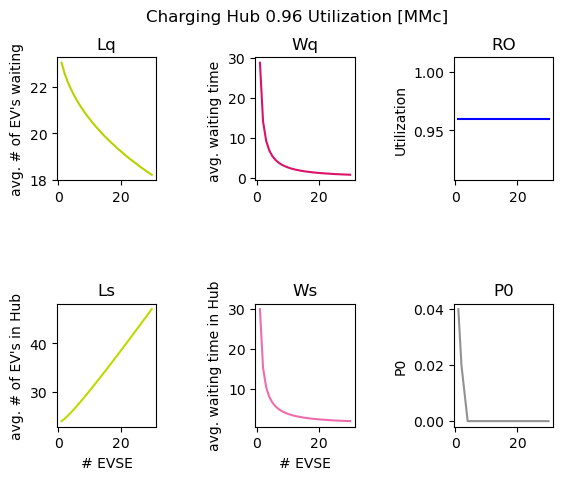

In [27]:
# use df as a copy of dfMathResults to make the plot
df= dfMathResults

# Create a figure and a 2x2 grid of subplots
fig, axs = plt.subplots(2, 3)

# # Add a title for the whole figure
fig.suptitle(f"Charging Hub {df.loc[1, 'RO']} Utilization [MMc]")

# Plot data on each subplot
axs[0, 0].plot(df.c, df.Lq, color= ENEXIS_G_0)
axs[0, 0].set_ylabel("avg. # of EV's waiting")
axs[0, 0].set_title(f"{df.Lq.name}")

axs[0, 1].plot(df.c, df.Wq, color=ENEXIS_P_0)
axs[0, 1].set_ylabel("avg. waiting time ")
axs[0, 1].set_title(f"{df.Wq.name}")

axs[1, 0].plot(df.c, df.Ls, color= ENEXIS_G_1)
axs[1, 0].set_ylabel("avg. # of EV's in Hub")
axs[1, 0].set_title(f"{df.Ls.name}")

axs[1, 1].plot(df.c, df.Ws, color=ENEXIS_P_1)
axs[1, 1].set_ylabel("avg. waiting time in Hub")
axs[1, 1].set_title(f"{df.Ws.name}")

axs[0, 2].plot(df.c, df.RO, color="#0000FF")
axs[0, 2].set_ylabel("Utilization")
axs[0, 2].set_title(f"{df.RO.name}")

axs[1, 2].plot(df.c, df.P0, color="#929292")
axs[1, 2].set_ylabel("P0")
axs[1, 2].set_title(f"{df.P0.name}")

# Plot data on each subplot
for i in range(2):
    for j in range(2):
        # axs[i, j].plot(x, y)
        # axs[i, j].set_title(f'Axis [{i}, {j}]')
        axs[1, j].set_xlabel("# EVSE")  # Set x-label for all subplots

# Adjust the space between subplots
plt.subplots_adjust(hspace=1, wspace=1)
plt.rcParams['font.family'] = 'DejaVu Sans'

# Save the plot
plt.savefig(f"./figures/total_{df.loc[0,'RO']}_{sim_session_name}.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


### Simulation

In [28]:
# simulation code for MMC queue
# function to run simulation
def sim_MMC(
    arrival_rate,
    processing_rate,
    charging_stations=1,
    sim_time=50000,
    time_unit="minutes",
    random_seed=123456,
    run=1,
):
    # Generator which creates cars
    class CarGenerator(sim.Component):
        # setup method is called when the component is created
        # and is used to initialize the component
        # switch off monitoring for mode and status
        def setup(self):
            self.mode.monitor(False)
            self.status.monitor(False)

        def process(self):
            while True:
                Car()
                self.hold(iat_distr.sample())

    class Car(sim.Component):
        def setup(self):
            self.mode.monitor(False)
            self.status.monitor(False)

        def process(self):
            self.enter(waitingline)
            for ChargingStation in ChargingStations:
                if ChargingStation.ispassive():
                    ChargingStation.activate()
                    break  # activate at most one charging station
            self.passivate()

    class ChargingStation(sim.Component):
        def setup(self):
            self.mode.monitor(False)
            self.status.monitor(False)

        def process(self):
            while True:
                while len(waitingline) == 0:
                    self.passivate()
                self.car = waitingline.pop()
                self.hold(srv_distr.sample())
                self.car.activate()

    N_STATION = charging_stations
    iat_distr = sim.Exponential(1 / arrival_rate)
    srv_distr = sim.Exponential(1 / processing_rate)

    # https://www.salabim.org/manual/Reference.html#environment
    app = sim.App(
        trace=False,  # defines whether to trace or not
        random_seed=random_seed,  # if “*”, a purely random value (based on the current time)
        time_unit=time_unit,  # defines the time unit used in the simulation
        name="Charging Station",  # name of the simulation
        do_reset=True,  # defines whether to reset the simulation when the run method is called
        yieldless=True,  # defines whether the simulation is yieldless or not
    )

    # Instantiate and activate the client generator
    CarGenerator(name="Electric Cars Generator")

    # Create Queue and set monitor to stats_only
    # https://www.salabim.org/manual/Queue.html
    waitingline = sim.Queue(name="Waiting Cars", monitor=True)
    # waitingline.length_of_stay.monitor(value=True)
    waitingline.length.reset_monitors(stats_only=True)
    waitingline.length_of_stay.reset_monitors(stats_only=True)

    # Instantiate the servers, list comprehension but only 1 server
    ChargingStations = [ChargingStation() for _ in range(N_STATION)]

    # Execute Simulation
    app.run(till=sim_time)

    # Return results
    return {
        "run": run,
        "lambda": arrival_rate,
        "mu": processing_rate,
        "c": charging_stations,
        "Wq": waitingline.length_of_stay.mean(),
        "Lq": waitingline.length.mean(),
    }


# function to run simulation X times
# returns a DataFrame with the results
def sim_x_MMC(
    arrival_rate,
    processing_rate,
    charging_stations=1,
    sim_time=50000,
    number_of_simulations=30,
):
    sim_runs = []

    # Run simulation X times with different random seeds
    for i in range(number_of_simulations):
        sim_runs.append(
            sim_MMC(
                arrival_rate=arrival_rate,
                processing_rate=processing_rate,
                charging_stations=charging_stations,
                sim_time=sim_time,
                random_seed=i,
                run=i,
            )
        )
        print(f"EVSE's {charging_stations}, run {i} completed at {datetime.now()}")

    # Concatenate all runs
    return pd.DataFrame(sim_runs)

#### Run Simulation

In [29]:
%%script false --no-raise-error # comment out this line to run the simulation CTRL + /
# Initialize an empty list
# Execute the simulation
dfs = []

for j in EVSES:
    df = sim_x_MMC(
        arrival_rate=j * arrival_rate,
        processing_rate=processing_rate,
        charging_stations=j,
        sim_time=sim_time,
        number_of_simulations=sim_reps,
    )

    # Append df to dfs
    dfs.append(df)

# Concatenate all DataFrames in dfs
df_total = pd.concat(dfs, ignore_index=True)

df_total.to_csv("./sim_results/" + sim_session_name)

In [30]:
# student-t distribution
# https://en.wikipedia.org/wiki/Student%27s_t-distribution#Table_of_selected_values
def t_sd(df, col, confidence_interval, sides="both", decimals=3):
    if sides != "both":
        ci = confidence_interval
    else:
        ci = confidence_interval + (1 - confidence_interval) / 2

    # column of interest
    x = df[col]

    # number of SD for confidence interval
    tdst = st.t.ppf(ci, df=x.__len__())

    return pd.DataFrame(
        {
            "c": df["c"].unique()[0],
            "name": col,
            "mean": x.mean().round(decimals),
            "lbnd": (x.mean() - tdst * x.std() / np.sqrt(x.__len__())).round(decimals),
            "ubnd": (x.mean() + tdst * x.std() / np.sqrt(x.__len__())).round(decimals),
            "stdv": x.std().round(decimals),
            "tdst": tdst.round(decimals),
            "runs": x.__len__(),
        },
        index=[0],
    )


# Calculate mean and confidence interval for waiting time
# df_evse = df_sim.groupby('c')['Wq'].agg(['mean', 'count']).reset_index()

# def mean_confidence_interval(data, confidence=0.95):
#     a = 1.0 * np.array(data)
#     n = len(a)
#     # m, se = np.mean(a), scipy.stats.sem(a)
#     m, se = np.mean(a), st.t.interval(confidence, n - 1, loc=np.mean(a), scale=st.sem(a))
#     return m, se

def sim_mean_and_ci(df_sim):
    # Calculate the mean and count for each 'c' group

    res = []
    for c in df_sim['c'].unique():
        df_evse = df_sim[df_sim['c'] == c]

        res.append(t_sd(df_evse, "Wq", confidence_interval=0.95, sides="both", decimals=3))
        # res.append(t_sd(df_evse, "Lq", confidence_interval=0.95, sides="both", decimals=3))

    # return results
    return pd.concat(res, axis=0, ignore_index=True)



In [31]:
# read df_total from csv
df_sim = pd.read_csv("./sim_results/" + sim_session_name)

# Get unique 'c' values
c_values = df_sim['c'].unique()

# Create a list of arrays, where each array contains the 'Lq' values for a unique 'c' value
data = [df_sim[df_sim['c'] == c]['Wq'].values for c in c_values]

df_sim_ci = sim_mean_and_ci(df_sim)
print(df_sim_ci)

     c name    mean    lbnd    ubnd    stdv   tdst  runs
0    1   Wq  23.153  18.395  27.910  10.200  2.086    20
1    2   Wq  12.875   8.195  17.556  10.035  2.086    20
2    3   Wq   7.758   6.437   9.080   2.834  2.086    20
3    4   Wq   6.358   4.963   7.753   2.991  2.086    20
4    5   Wq   5.536   4.517   6.554   2.183  2.086    20
5    6   Wq   4.721   3.900   5.541   1.759  2.086    20
6    7   Wq   3.964   3.179   4.748   1.682  2.086    20
7    8   Wq   2.936   2.581   3.292   0.763  2.086    20
8    9   Wq   2.946   2.566   3.326   0.815  2.086    20
9   10   Wq   2.299   2.008   2.589   0.623  2.086    20
10  11   Wq   2.209   1.926   2.493   0.609  2.086    20
11  12   Wq   1.944   1.703   2.185   0.517  2.086    20
12  13   Wq   1.627   1.445   1.809   0.390  2.086    20
13  14   Wq   1.568   1.379   1.756   0.404  2.086    20
14  15   Wq   1.581   1.486   1.676   0.204  2.086    20
15  16   Wq   1.550   1.364   1.737   0.399  2.086    20
16  17   Wq   1.490   1.214   1

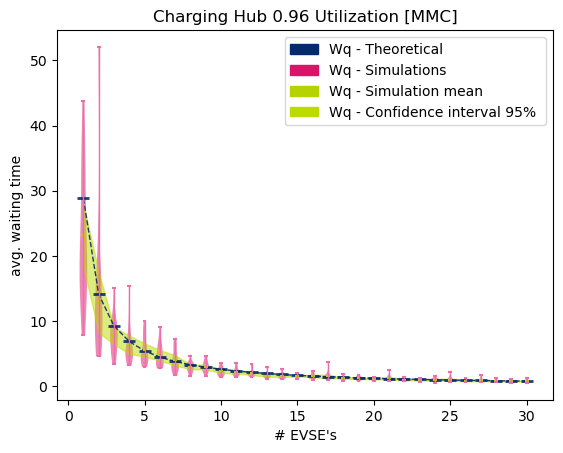

In [32]:
# Create a line plot
plt.plot(
    df.c,
    df.Wq,
    label="Wq - math",
    color=ENEXIS_B_0,
    marker="_",
    linestyle="dashed",
    linewidth=1,
    markersize=8,
    alpha=0.9,
    markerfacecolor=ENEXIS_B_0,
    markeredgecolor=ENEXIS_B_0,
    markeredgewidth=2,
)

plt.fill_between(
    df_sim_ci['c'], 
    df_sim_ci['lbnd'], 
    df_sim_ci['ubnd'], 
    color=ENEXIS_G_1, 
    alpha=0.5
    )


# Create a violin plot for the second data series
parts = plt.violinplot(data, positions=c_values, showmeans=True, showmedians=False)

# Coloring the violin plot
for pc in parts['bodies']:
    pc.set_facecolor(ENEXIS_P_0)
    pc.set_zorder(0)
    pc.set_linewidth(1)
    pc.set_alpha(0.5)
    pc.set_label("Wq - sim")

parts['cmeans'].set_color(ENEXIS_G_0)
parts['cmaxes'].set_color(ENEXIS_P_1)
parts['cmins'].set_color(ENEXIS_P_1)
parts['cbars'].set_color(ENEXIS_P_1)
parts['cbars'].set_linewidth(1)

# Create a patch 
violin_patch_the = mpatches.Patch(color=ENEXIS_B_0, label='Wq - Theoretical')
violin_patch_sim = mpatches.Patch(color=ENEXIS_P_0, label='Wq - Simulations')
violin_patch_avg = mpatches.Patch(color=ENEXIS_G_0, label='Wq - Simulation mean')
violin_patch_int = mpatches.Patch(color=ENEXIS_G_1, label='Wq - Confidence interval 95% ')

# Add labels and title
plt.xlabel("# EVSE's")
plt.ylabel("avg. waiting time")
plt.title(f"Charging Hub {df.loc[1, 'RO']} Utilization [MMC]")
plt.legend(handles=[ violin_patch_the, violin_patch_sim, violin_patch_avg, violin_patch_int])

# Save the plot
plt.savefig(f"./figures/math_vs_sim_{df.loc[0,'RO']}_{sim_session_name}.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


## Example 1

Cars arrive at a single charging station according to a Poisson input process with a mean rate of 40 per hour. The time required to charge a car has an exponential distribution with a mean of 50 per hour. Cars are charged by a single charging station.

> Find the average waiting time of a car.

#### Solution

Given:

$\lambda = 40/hour$, $\mu = 50/hour$

Average waiting time of a car before receiving service ($W_q$) = $\cfrac{40}{50(50-40)}$ = 4.8 minutes

#### Simulation of Example 1

In [ ]:
# mathematically calculated results
# instantanious
print_mm1(40 / 60, 50 / 60)

In [ ]:
# mathematically calculated results
# instantanious
print_mmc(40 / 60, 50 / 60, 1)

In [ ]:
# Run simulation X times with different random seeds
# takes about 20 seconds for 20 simulations of 7 days = 10080
print(
    MMc_clt(
        arrival_rate=40 / 60,  # cars per hour
        processing_rate=50 / 60,  # cars per hour
        charging_stations=1,  # charging station
        sim_time=60 * 24 * 7,  # minutes in a week
        number_of_simulations=20,  # simulations
        confidence_interval=0.95,  # confidence interval
    ).to_string(index=False)
)

## Example 2

New Delhi Charging Hub has a single charging station. During the rush hours, customers arrive at the rate of 10 per hour. The average number of customers that can be served is 12 per hour. Find out the following:

1. Probability that the ticket counter is free.
1. Average number of customers in the queue.


### Solution

Given:

$\lambda = 10/hour$, $\mu = 12/hour$

1. Probability that the charging station is free ($P_o$) = $1 - \cfrac{\lambda}{\mu} = 1 - \cfrac{10}{12} = \cfrac{1}{6}$
1. Average number of customers in the queue ($L_q$ ) = $\cfrac{\lambda^2}{\mu(\mu-\lambda)} = \cfrac{10^2}{12(12-10)} = \cfrac{25}{6} = 4.16666$
   

#### Simulation of Example 2

In [ ]:
print_mm1(10 / 60, 12 / 60)

In [ ]:
# mathematically calculated results
# instantanious
print_mmc(10 / 60, 12 / 60, 1   )

In [ ]:
# Run simulation X times with different random seeds
# takes about 25 seconds for 20 simulations of 28 days = 40320
print(
    MMc_clt(
        arrival_rate=10 / 60,  # cars per hour
        processing_rate=12 / 60,  # cars per hour
        charging_stations=1,  # charging station
        sim_time=60 * 24 * 7 * 4,  # minutes in a month
        number_of_simulations=20,  # simulations
        confidence_interval=0.95,  # confidence interval
    ).to_string(index=False)
)

## Example 3

At Bharat charging station, cars arrive according to a Poisson process with an average time of 5 minutes between arrivals. The service time is exponentially distributed with mean time = 2 minutes. On the basis of this information, find out

1. What would be the average queue length?
1. What is the average waiting time of a car before receiving petrol?
1. What would be the average number of customers in the queuing system?
1. What is the average time spent by a car in the petrol pump?

### Solution

Given  

$\lambda = 12/hour$, $\mu = 30/hour$

Average inter arrival time = $\cfrac{1}{\lambda} = 5 minutes = \cfrac{1}{12} = \lambda = 12/hour$
 	 	 	 	 
Average service time =	$\cfrac{1}{\mu} = 2 minutes = \cfrac{1}{30} = \mu = 30/hour$


 Performance Indicator                                                 | Formula 
:----------------------------------------------------------------------|:-----------------------------------------------
 Average queue length ($L_q$ )                                         | $ = \cfrac{12^2}{30(30-12)} = \cfrac{4}{15}$
 Average waiting time of a car before being charged ($W_q$)            | $ = \cfrac{12}{30(30-12)} = $ 1.33 minutes
 Average number of customers, ($L_s$)                                  | $ = \cfrac{12}{30-12} = \cfrac{2}{3}$	 
 Average time spent at the charging station ($W_s$)                    | $ = \cfrac{1}{\mu-\lambda} = \cfrac{1}{30-12} = $ 3.33 minutes

In [ ]:
print_mm1(12 / 60, 30 / 60)

In [ ]:
# mathematically calculated results
# instantanious
print_mmc(12 / 60, 30 / 60, 1   )


In [ ]:
# Run simulation X times with different random seeds
# takes about 30 seconds for 20 simulations of 28 days = 40320
print(
    MMc_clt(
        arrival_rate=12 / 60,  # cars per hour
        processing_rate=30 / 60,  # cars per hour
        charging_stations=1,  # charging station
        sim_time=60 * 24 * 7 * 4,  # minutes in a month
        number_of_simulations=20,  # simulations
        confidence_interval=0.95,  # confidence interval
    ).to_string(index=False)
)

In [ ]:
%%script false --no-raise-error
# Resource method
# https://www.salabim.org/manual/Modelling.html#the-bank-office-example-with-resources

import salabim as sim


class CarGenerator(sim.Component):
    def setup(self):
        self.mode.monitor(False)
        self.status.monitor(False)

    def process(self):
        while True:
            Car(name="Car")
            self.hold(iat_distr.sample())


class Car(sim.Component):
    def setup(self):
        self.mode.monitor(False)
        self.status.monitor(False)

    def process(self):
        self.request(chargingstations)
        self.hold(srv_distr.sample())
        self.release()  # not really required


N_STATION = 1
iat_distr = sim.Exponential(60 / 12)  # lambda = 12/hour
srv_distr = sim.Exponential(60 / 30)  # mu     = 30/hour

# https://www.salabim.org/manual/Reference.html#environment
app = sim.App(
    trace=False,  # defines whether to trace or not
    random_seed="*",  # if “*”, a purely random value (based on the current time)
    time_unit="minutes",  # defines the time unit used in the simulation
    name="Charging Station",  # name of the simulation
    do_reset=True,  # defines whether to reset the simulation when the run method is called
    yieldless=True,  # defines whether the simulation is yieldless or not
)

# Instantiate and activate the client generator
CarGenerator(name="Electric Cars Generator")

# Instantiate the servers, list comprehension but only 1 server
chargingstations = sim.Resource(
    name="EVSE's", capacity=N_STATION, monitor=True
)
chargingstations.requesters().length_of_stay.monitor(value=True)

# Execute Simulation
app.run(till=50000)

# Print statistics
# chargingstations.print_statistics()

Lq = chargingstations.requesters().length.mean()
Ls = Lq + chargingstations.occupancy.mean()
Wq = chargingstations.requesters().length_of_stay.mean()
Ws = Wq + srv_distr.mean()


print(
    "\n",
    "Average queue length: \t\t\t\t\t",
    Lq,
    "\n",
    "Average number of customers: \t\t\t\t",
    Ls,
    "\n",
    "Average time spent at the charging station: \t\t",
    Ws,
    "\n",
    "Average waiting time of a car before being charged: \t",
    Wq,
)

## Example 4

Enexis is considering to operate a single charging station. Management estimates that customers will arrive at the rate of 15 per hour. The charging station can charge a car at the rate of one every 3 minutes.

Assuming Poisson arrivals and exponential service find

1. Average number in the waiting line.
1. Average waiting time in line.
1. Average number in the system.
1. Average waiting time in the system.

### Solution.
Given  

$\lambda = 15/hour$, $\mu = 20/hour$

 Performance Indicator                                                 | Formula 
:----------------------------------------------------------------------|:-----------------------------------------------
 Average queue length ($L_q$ )                                         | $ = \cfrac{15^2}{20(20-15)} = $ 2.25 cars
 Average waiting time of a car before being charged ($W_q$)            | $ = \cfrac{15}{20(20-15)} = $ 0.15 hours = 9 minutes
 Average number of customers, ($L_s$)                                  | $ = \cfrac{15}{20-15} = $ 3 cars	
 Average time spent at the charging station ($W_s$)                    | $ = \cfrac{1}{\mu-\lambda} = \cfrac{1}{20-15} = $ 12 minutes 

In [ ]:
print_mm1(15/60,20/60)

In [ ]:
print_mmc(15/60,20/60,1)

In [ ]:
# Run simulation X times with different random seeds
# takes about 35 seconds for 20 simulations of 28 days = 40320
print(
    MMc_clt(
        arrival_rate=15 / 60,  # cars per hour
        processing_rate=20 / 60,  # cars per hour
        charging_stations=1,  # charging station
        sim_time=60 * 24 * 7 * 4,  # minutes in a month
        number_of_simulations=20,  # simulations
        confidence_interval=0.95,  # confidence interval
    ).to_string(index=False)
)

In [ ]:
%%script false --no-raise-error
# Resource method
# https://www.salabim.org/manual/Modelling.html#the-bank-office-example-with-resources

import salabim as sim


class CarGenerator(sim.Component):
    def setup(self):
        self.mode.monitor(False)
        self.status.monitor(False)        

    def process(self):
        while True:
            Car(name="Car")
            self.hold(iat_distr.sample())


class Car(sim.Component):
    def setup(self):
        self.mode.monitor(False)
        self.status.monitor(False)        

    def process(self):
        self.request(chargingstations)
        self.hold(srv_distr.sample())
        self.release()  # not really required


N_STATION = 1
iat_distr = sim.Exponential(60 / 15)  # lambda = 12/hour
srv_distr = sim.Exponential(60 / 20)  # mu     = 30/hour

# https://www.salabim.org/manual/Reference.html#environment
app = sim.App(
    trace=False,  # defines whether to trace or not
    random_seed="*",  # if “*”, a purely random value (based on the current time)
    time_unit="minutes",  # defines the time unit used in the simulation
    name="Charging Station",  # name of the simulation
    do_reset=True,  # defines whether to reset the simulation when the run method is called
    yieldless=True,  # defines whether the simulation is yieldless or not
)

# Instantiate and activate the client generator
CarGenerator(name="Electric Cars Generator")

# Instantiate the servers, list comprehension but only 1 server
chargingstations = sim.Resource(
    name="EVSE's", capacity=N_STATION, monitor=True
)
chargingstations.requesters().length_of_stay.monitor(value=True)

# Execute Simulation
app.run(till=50000)

# Print statistics
# chargingstations.print_statistics()

Lq = chargingstations.requesters().length.mean()
Ls = Lq + chargingstations.occupancy.mean()
Wq = chargingstations.requesters().length_of_stay.mean()
Ws = Wq + srv_distr.mean()


print(
    "\n",
    "Average queue length: \t\t\t\t\t",
    Lq,
    "\n",
    "Average number of customers: \t\t\t\t",
    Ls,
    "\n",
    "Average waiting time of a car before being charged: \t",
    Wq,
    "\n",
    "Average time spent at the charging station: \t\t",
    Ws,
)

## Example 5

Chhabra Saree Emporium has a single charging station. During the rush hours, cars arrive at the rate of 10 per hour. The average number of customers that can be processed by the charging station is 12 per hour. On the basis of this information, find the following:

1. Probability that the charging station is idle
1. Average number of customers in the queue
1. Average time a customer spends in the queue
1. Average number of cars in the queuing system
1. Average time a customer spends in the system


### Solution.
Given  

$\lambda = 10/hour$, $\mu = 12/hour$

 Performance Indicator                                     | Formula 
:----------------------------------------------------------|:-----------------------------------------------
 Probability of zero unit in the queue ($P_o$)             | $ = 1 - \cfrac{\lambda}{\mu} = 1 - \cfrac{10}{12} = \cfrac{1}{6}$
 Average queue length ($L_q$ )                             | $ = \cfrac{\lambda^2}{\mu(\mu-\lambda)} = \cfrac{10^2}{12(12-10)} = \cfrac{25}{6}$ cars
 Average waiting time of an arrival ($W_q$)                | $ = \cfrac{\lambda}{\mu(\mu-\lambda)} = \cfrac{10}{12(12-10)} = $ 25 minutes
 Average number of units in the system ($L_s$)             | $ = \cfrac{\lambda}{\mu-\lambda} = \cfrac{10}{12-10} = $ 5 cars
 Average waiting time of an arrival in the system ($W_s$)  | $ = \cfrac{1}{\mu-\lambda} = \cfrac{1}{12-10} =$ 30 minutes
 
 

In [ ]:
print_mm1(10 / 60, 12 / 60)

In [ ]:
print_mmc(10 / 60, 12 / 60, 1)

In [ ]:
# Run simulation X times with different random seeds
# takes about 30 seconds for 30 simulations of 28 days = 40320
print(
    MMc_clt(
        arrival_rate=10 / 60,  # cars per hour
        processing_rate=12 / 60,  # cars per hour
        charging_stations=1,  # charging station
        sim_time=60 * 24 * 7 * 4,  # minutes in a month
        number_of_simulations=30,  # simulations
        confidence_interval=0.95,  # confidence interval
    ).to_string(index=False)
)

In [ ]:
%%script false --no-raise-error
# Resource method
# https://www.salabim.org/manual/Modelling.html#the-bank-office-example-with-resources

import salabim as sim


class CarGenerator(sim.Component):
    def setup(self):
        self.mode.monitor(False)
        self.status.monitor(False)        

    def process(self):
        while True:
            Car(name="Car")
            self.hold(iat_distr.sample())


class Car(sim.Component):
    def setup(self):
        self.mode.monitor(False)
        self.status.monitor(False)        

    def process(self):
        self.request(chargingstations)
        self.hold(srv_distr.sample())
        self.release()  # not really required


N_STATION = 1
iat_distr = sim.Exponential(60 / 10)  # lambda = 10/hour
srv_distr = sim.Exponential(60 / 12)  # mu     = 12/hour

# https://www.salabim.org/manual/Reference.html#environment
app = sim.App(
    trace=False,  # defines whether to trace or not
    random_seed="*",  # if “*”, a purely random value (based on the current time)
    time_unit="minutes",  # defines the time unit used in the simulation
    name="Charging Station",  # name of the simulation
    do_reset=True,  # defines whether to reset the simulation when the run method is called
    yieldless=True,  # defines whether the simulation is yieldless or not
)

# Instantiate and activate the client generator
CarGenerator(name="Electric Cars Generator")

# Instantiate the servers, list comprehension but only 1 server
chargingstations = sim.Resource(
    name="EVSE's", capacity=N_STATION, monitor=True
)
chargingstations.requesters().length_of_stay.monitor(value=True)

# Execute Simulation
app.run(till=50000)

# Print statistics
# chargingstations.print_statistics()

P0 = 1 - chargingstations.occupancy.mean()
Lq = chargingstations.requesters().length.mean()
Ls = Lq + chargingstations.occupancy.mean()
Wq = chargingstations.requesters().length_of_stay.mean()
Ws = Wq + srv_distr.mean()


print(
    "\n",
    "Probability that the charging station is free: \t",
    P0,
    "\n",
    "Average number of customers: \t\t\t\t",
    Ls,    
    "\n",
    "Average time spent at the charging station: \t\t",
    Ws,    
    "\n",
    "Average queue length: \t\t\t\t\t",
    Lq,
    "\n",
    "Average waiting time of a car before being charged: \t",
    Wq,

)